In [186]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
from tqdm import tqdm
import pulp

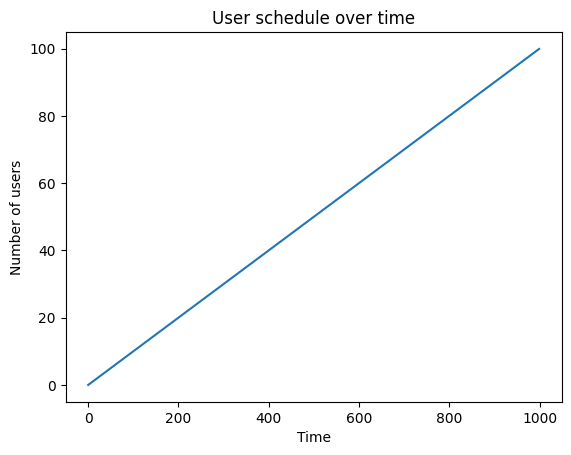

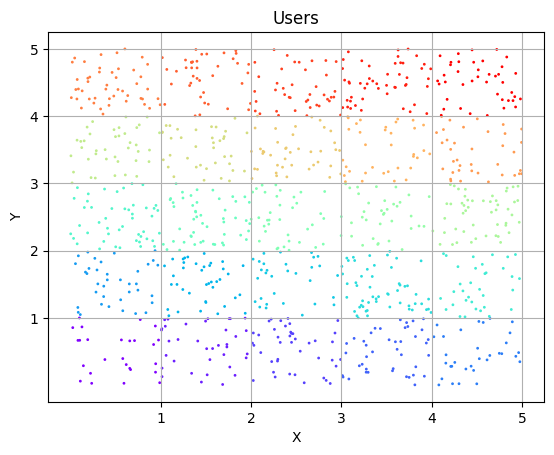

user_ids [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [184]:
def generate_user_schedule(num_time_steps, max_users):
  """
  controls the number of users in the network
  slowly increases number of users linearly over time
  """
  user_schedule = []
  return [(max_users/num_time_steps) * t for t in range(num_time_steps)]
  # return [max_users for t in range(num_time_steps)]


def generate_users(user_schedule, distribution="uniform", distribution_matrix=None):
    """
    params:
      distribution_matrix (list): a list containing the demands for each user
    """
    users = []

    user_id = 0
    assert distribution in ["uniform", "random", "bipeak", "special"]
    # Define a density matrix for the 5x5 grid.
    # Higher values represent areas with more population density.
    if distribution == "random":
      density = np.array([
          [0.5, 1,   1.5, 1,   0.5],
          [1,   2,   5,   2,   1],
          [1.5, 3,   0.5,   3,   1.5],
          [1,   5,   3,   2,   1],
          [0.5, 1,   1.5, 1,   0.5]
      ])
    elif distribution == "bipeak":
      density = np.array([
          [0.5, 0.25,   0.3, 0.1,   0.5],
          [0.5,   0.1,   0.6,   0.1,   0.3],
          [0.3, 5,   0.5,   6,   1.5],
          [0.1,   5,   0.3,   0.4,   0.1],
          [0.5, 0.1,   0.6, 0.5,   0.4]
      ])
    elif distribution == "special":
      density = np.array(distribution_matrix)
    else:
      density = np.array([
        [1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0]
      ])


    # Flatten the density matrix and normalize it to get probabilities
    density_flat = density.flatten()
    prob = density_flat / density_flat.sum()

    
    for t in range(len(user_schedule)):
      if t==0:
        num_users_to_add = int(user_schedule[0])
      else:
        num_users_to_add = int(user_schedule[t])-int(user_schedule[t-1])
      
      temp = []
      for user_idx in range(num_users_to_add):
        # Randomly select a cell index based on the weighted probability distribution
        cell_index = np.random.choice(np.arange(25), p=prob)

        # Convert cell index to 2D grid coordinates (row, col)
        row = cell_index // 5
        col = cell_index % 5

        # Assume the entire area spans from 0 to 5 in both directions.
        # Generate a random offset within the cell (each cell is 1x1)
        x = col + np.random.rand()
        y = row + np.random.rand()
        position = (x, y)

        # Create and add the new User
        temp.append(User(user_id, None, position, 1))
        user_id += 1
      users.append(temp)

    return users



def assign_users_to_cells(users):
  """
  assumes a 5x5 grid
  assigns a unique user id to each user in the nested list of users
  """
  for t in range(len(users)):
    for user in users[t]:
      x_idx = np.floor(user.position[0])
      y_idx = np.floor(user.position[1])
      cell_id = x_idx + y_idx * 5
      user.cell_id = cell_id

def assign_users_to_sats(users, sats):
  """
  assign users directly beneath sats to sats 
  """
  for t in range(len(users)):
    for user in users[t]:
      cell_id = user.cell_id
      for sat in sats:
        if sat.cell_id == cell_id:
          sat.add_user(user.user_id)
          break

def plot_user_schedule(user_schedule):
  """"""
  plt.plot(user_schedule)
  plt.xlabel("Time")
  plt.ylabel("Number of users")
  plt.title("User schedule over time")
  plt.show()

user_schedule = generate_user_schedule(1000, 100)
plot_user_schedule(user_schedule)

def plot_users(users):
  position_x = []
  position_y = []
  colors = []

  for t in range(len(users)):
    for user in users[t]:
      position_x.append(user.position[0])
      position_y.append(user.position[1])
      colors.append(user.cell_id)


  plt.scatter(position_x, position_y, c=colors, cmap="rainbow", s=1)
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Users")
  plt.xticks(np.arange(1, 6, 1))  # X-axis ticks from 1 to 25
  plt.yticks(np.arange(1, 6, 1))  # Y-axis ticks from 1 to 25
  plt.grid()
  plt.show()

def print_users(users):
  user_ids = []
  for t in range(len(users)):
    for user in users[t]:
      user_ids.append(user.user_id)
      # user.print_user()
  print("user_ids", user_ids)

user_schedule = generate_user_schedule(1000, 1000)

users = generate_users(user_schedule) # returns a nested list of users
assign_users_to_cells(users)
plot_users(users)
print_users(users)




# print(user_schedule)

In [3]:
class Satellite:
  def __init__(self, total_capacity, cell_id, num_time_steps):
    self.NULL_CAP_MULTIPLIER = 25
    self.total_capacity = total_capacity
    self.capacity = total_capacity
    self.null_capacity = total_capacity * self.NULL_CAP_MULTIPLIER # TODO: this is a very simple assumption for now, should be 25x
    self.cell_id = cell_id
    self.users = [] # these are the users assigned to the cell directly beneath the sat
    self.full = False
    self.N_0 = 0
    self.N_1 = 0
    self.N_2 = 0

  def add_user(self, user_id):
    self.users.append(user_id)

  def remove_user(self, user_id):
    self.users.remove(user_id)

  def print_sat(self):
    print(f"Satellite {self.cell_id}: total cap={self.total_capacity}), remaining cap={self.capacity}, num users={len(self.users)}")

  def reset_sat(self):
    self.capacity = self.total_capacity
    self.null_capacity = self.total_capacity * self.NULL_CAP_MULTIPLIER
    self.full = False
    self.N_0 = 0
    self.N_1 = 0
    self.N_2 = 0



class User:
  """we currently treat users as existing over a single time step since all users are equal """
  def __init__(self, user_id, cell_id, position, demand):
    self.user_id = user_id
    self.cell_id = cell_id
    self.position = position
    self.demand = demand

    self.sat_id = None
    self.tag = None


  def print_user(self):
    print(f"User {self.user_id}: cell={self.cell_id}, position={self.position}, demand={self.demand}, sat_id={self.sat_id}")

  def reset_user(self):
    pass


In [182]:
def simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=1000, total_capacity=10,
                     max_users=100, revenue_factor=100, penalty_factor=100, distribution="uniform", distribution_matrix=None, 
                     use_stage_1=True, use_stage_2=True, use_stage_3=True):
  """"""
  # generate an array to keep track of satellite capacities and metadata for each satellite 
  sats = [Satellite(total_capacity=total_capacity, cell_id=i, num_time_steps=num_time_steps) for i in range(num_sats)]

  # generate users randomly distributed in space within the cell for all time steps
  user_schedule = generate_user_schedule(num_time_steps, max_users)

  result = three_stage_mac(sats, user_schedule, num_time_steps, revenue_factor=revenue_factor, penalty_factor=penalty_factor, distribution=distribution,
                           distribution_matrix=distribution_matrix, use_stage_1=use_stage_1, use_stage_2=use_stage_2, use_stage_3=use_stage_3, )

  # TODO: track avg throughput for each user
  return {"sats": sats, "revenues": result["revenues"], "penalties": result["penalties"],
          "num_served_by_normal":result["num_served_by_normal"], "num_served_by_sharing":result["num_served_by_sharing"],
          "num_served_by_nulling":result["num_served_by_nulling"], "num_unserved":result["num_unserved"]}

def three_stage_mac(sats, user_schedule, num_time_steps, revenue_factor=100, penalty_factor=100, distribution="uniform", distribution_matrix=None,
                     use_stage_1=True, use_stage_2=True, use_stage_3=True, verbose=False):

  revenues = []
  penalties = []

  num_served_by_normal = []
  num_served_by_sharing = []
  num_served_by_nulling = []
  num_unserved = []

  all_users = generate_users(user_schedule, distribution=distribution, distribution_matrix=distribution_matrix) # a list of users at each time step to be added into the network

  assign_users_to_cells(all_users)
  assign_users_to_sats(all_users, sats)

  plot_users(all_users)

  num_nulling = 0
  num_sharing = 0
  num_normal = 0

  unserved_users = {}
  served_users = {}
  
  for t in tqdm(range(num_time_steps), desc="Simulating Time Steps"):
    
    # print("user_schedule[t]", int(user_schedule[t]))
    users_to_add = all_users[t] # a list of users to add at time step t

    if verbose:
      print("*********************")
      print(f"Time Step {t}:")
      print("*********************")
    

    # stage 1: if the sat assigned to that user's region is not full, assign it to that satellite
    if use_stage_1:
      for user in users_to_add:
        if user.demand > sats[int(user.cell_id)].capacity:
          user.sat_id = None
          user.tag = "unserved"
          unserved_users.update({user.user_id:user})
          
        else:
          user.sat_id = sats[int(user.cell_id)].cell_id # TODO: technically we don't need to do this?
          user.tag = "normal"
          served_users.update({user.user_id:user})
          sats[int(user.cell_id)].capacity -= user.demand
          num_normal += 1
      
    # stage 2: for all the users not yet assigned a satellite, iterate through satellites with capacity to share and assign 
    # TODO: currently any sat can be used for sharing (irrespective of where it is located spatially), should we change this? 
    if use_stage_2:
      newly_served_users = []
      for user_id in unserved_users:
        for sat in sats:
          if unserved_users[user_id].demand > sat.capacity:
            # sat has not more available capacity to share
            continue
          else:
            newly_served_users.append(user_id)
            user = unserved_users[user_id]
            user.sat_id = sat.cell_id
            user.tag = "sharing"
            sat.capacity -= user.demand
            served_users.update({user_id:user})
            num_sharing += 1
            break
      for user_id in newly_served_users:
        unserved_users.pop(user_id)

        
    # stage 3: for remaining users, assign them using nulling waterfilling
    if use_stage_3:
      for sat in sats:
        for user_id in sat.users:
          if user_id in unserved_users:
            # not yet been served, so we will serve using nulling
            # check that we still have nulling capacity left
            # 10*25-10=240 -> 240/25=9.6
            # currently max users served by nulling for each sat is 240 users
            # TODO: implement N1 and N0
            if sat.N_0 * 1/25 + sat.N_1 * 1/6.25 + sat.N_2 * 1/1.265 <= 9.6:
              sat.N_0 += 1
              user = unserved_users.pop(user_id)
              user.sat_id = sat.cell_id
              user.tag = "nulling"
              num_nulling += 1
              served_users.update({user_id:user})
      # TODO: go through sats except this time loop through all users in N1 cells
      # TODO: go through sats except this time loop through all users in N2 cells


    # TODO: any remaining users are marked as unserved, may want to keep track of how long they have been unserved for and create
    # some sort of priority queue so that when capacity opens up they are served first
    # print(f"Total user in network at time {t}", len(served_users) + len(unserved_users))
    revenues.append(len(served_users) * revenue_factor)
    penalties.append(len(unserved_users) * penalty_factor)

    num_served_by_normal.append(num_normal)
    num_served_by_sharing.append(num_sharing)
    num_served_by_nulling.append(num_nulling)
    num_unserved.append(len(unserved_users))

  print("Number of users served by nulling:", num_served_by_nulling)
  print("Total number of users:", len(users))
  return {"revenues": revenues, "penalties": penalties,
          "num_served_by_normal": num_served_by_normal, "num_served_by_sharing": num_served_by_sharing,
          "num_served_by_nulling": num_served_by_nulling, "num_unserved": num_unserved}



In [160]:
def summarize_results(result, num_time_steps, animate=False):
  revenues = result["revenues"]
  penalties = result["penalties"]

  profit = np.array(revenues) - np.array(penalties)

  plt.plot(revenues)
  plt.xlabel("Time")
  plt.ylabel("Revenue")
  plt.title("Revenue over time")
  plt.show()

  plt.plot(penalties)
  plt.xlabel("Time")
  plt.ylabel("Penalty")
  plt.title("Penalty over time")
  plt.show()

  plt.plot(profit)
  plt.xlabel("Time")
  plt.ylabel("Profit")
  plt.title("Profit over time")
  plt.show()

  # plt.plot(np.array(profit)/(np.array(revenues)+1e-9))
  # plt.xlabel("Time")
  # plt.ylabel("Gain")
  # plt.title("Ratio of Experimental/Baseline (No Penalty)")
  # plt.show()

  # plot the proportion of users who are normal, sharing, nulling, and unserved over time
  num_served_by_normal = result["num_served_by_normal"]
  num_served_by_sharing = result["num_served_by_sharing"]
  num_served_by_nulling = result["num_served_by_nulling"]
  num_unserved = result["num_unserved"]

  plt.plot(num_served_by_normal, label='normal')
  plt.plot(num_served_by_sharing, label='sharing')
  plt.plot(num_served_by_nulling, label='nulling')
  plt.plot(num_unserved, label='unserved')
  plt.legend()
  plt.xlabel("Time")
  plt.ylabel("Number of users")
  plt.yscale('log')
  plt.title("Breakdown of users over time")
  plt.show()

  plt.plot(np.array(num_served_by_normal)*100, label='normal')
  plt.plot(np.array(num_served_by_sharing)*100, label='sharing')
  plt.plot(np.array(num_served_by_nulling)*100, label='nulling')
  plt.plot(np.array(num_unserved), label='unserved')
  plt.legend()
  plt.xlabel("Time")
  plt.ylabel("Revenue")
  plt.yscale('log')
  plt.title("Breakdown of Revenue over time")
  plt.show()


  # if animate:
  #   animation = plot_users_spatially_animated(sats, users, num_time_steps, save_gif=True)

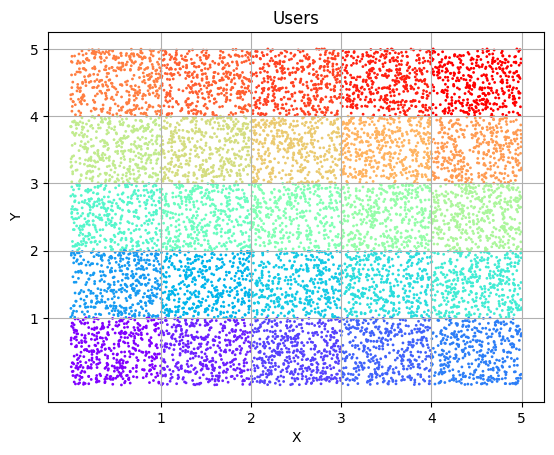

Simulating Time Steps: 100%|██████████| 100/100 [00:00<00:00, 53669.92it/s]


Number of users served by nulling: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of users: 1000


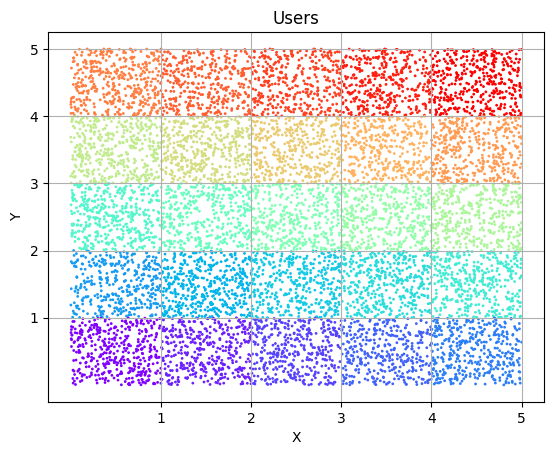

Simulating Time Steps: 100%|██████████| 100/100 [00:00<00:00, 427.92it/s]


Number of users served by nulling: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of users: 1000


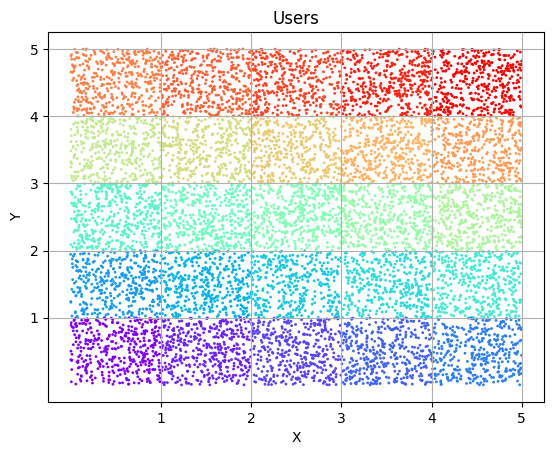

Simulating Time Steps: 100%|██████████| 100/100 [00:00<00:00, 1504.98it/s]


Number of users served by nulling: [0, 0, 0, 50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050, 3150, 3250, 3350, 3450, 3550, 3650, 3750, 3850, 3950, 4050, 4150, 4250, 4350, 4450, 4550, 4650, 4750, 4850, 4950, 5050, 5150, 5250, 5350, 5450, 5545, 5636, 5717, 5798, 5865, 5910, 5940, 5960, 5979, 5997, 6017, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025, 6025]
Total number of users: 1000


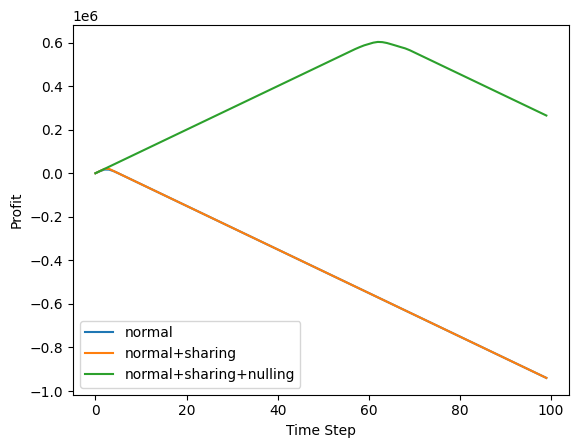

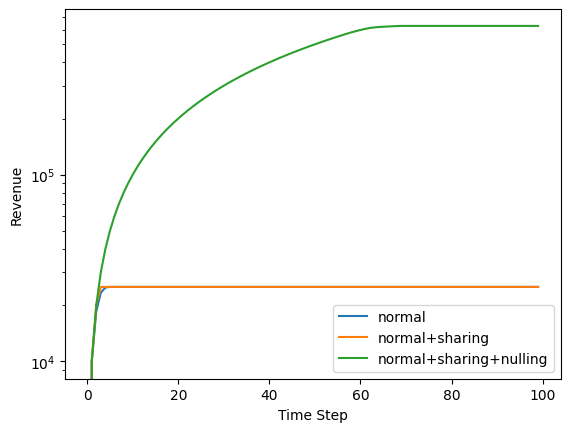

In [159]:
# normal only
num_time_steps = 100
max_users = 10000
result_1 = simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=num_time_steps, total_capacity=10,
                     max_users=max_users, revenue_factor=100, penalty_factor=100, distribution="uniform",
                     use_stage_1=True, use_stage_2=False, use_stage_3=False)

# normal + sharing 
result_2 = simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=num_time_steps, total_capacity=10,
                     max_users=max_users, revenue_factor=100, penalty_factor=100, distribution="uniform",
                     use_stage_1=True, use_stage_2=True, use_stage_3=False)

# normal + sharing + nulling
result_3 = simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=num_time_steps, total_capacity=10,
                     max_users=max_users, revenue_factor=100, penalty_factor=100, distribution="uniform",
                     use_stage_1=True, use_stage_2=True, use_stage_3=True)

result_1_profit = np.array(result_1["revenues"]) - np.array(result_1["penalties"])
result_2_profit = np.array(result_2["revenues"]) - np.array(result_2["penalties"])
result_3_profit = np.array(result_3["revenues"]) - np.array(result_3["penalties"])


plt.plot(result_1_profit, label="normal")
plt.plot(result_2_profit, label="normal+sharing")
plt.plot(result_3_profit, label="normal+sharing+nulling")
# plt.yscale("log")
plt.ylabel("Profit")
plt.xlabel("Time Step")
plt.legend()
plt.show()


plt.plot(result_1["revenues"], label="normal")
plt.plot(result_2["revenues"], label="normal+sharing")
plt.plot(result_3["revenues"], label="normal+sharing+nulling")
plt.yscale("log")
plt.ylabel("Revenue")
plt.xlabel("Time Step")
plt.legend()
plt.show()


How would we plot the upper bound from the one shot optimization?
Ideas:
- choose an mean and std dev for gamma distribution, run the one shot optimization with these params
- run the same simulation but using the demand matrix to skew the uniform distrb and run the 3 stage optimization
- compare the results

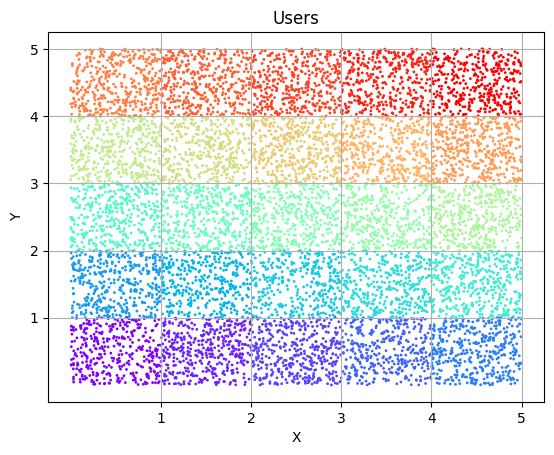

Simulating Time Steps: 100%|██████████| 100/100 [00:00<00:00, 57796.67it/s]


Number of users served by nulling: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of users: 1000


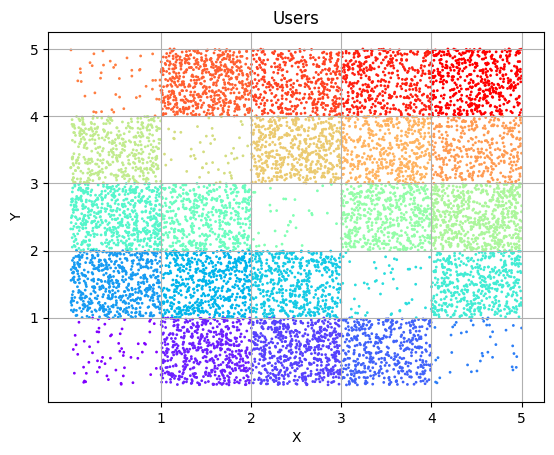

Simulating Time Steps: 100%|██████████| 100/100 [00:00<00:00, 1075.82it/s]

Number of users served by nulling: [0, 0, 0, 50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950, 2050, 2150, 2250, 2350, 2450, 2550, 2650, 2750, 2850, 2950, 3050, 3150, 3250, 3350, 3450, 3543, 3639, 3735, 3828, 3920, 4006, 4087, 4161, 4228, 4294, 4347, 4392, 4431, 4471, 4497, 4535, 4561, 4585, 4610, 4626, 4645, 4663, 4680, 4694, 4709, 4719, 4726, 4734, 4742, 4749, 4762, 4764, 4766, 4767, 4772, 4773, 4779, 4785, 4786, 4788, 4794, 4796, 4797, 4800, 4803, 4808, 4810, 4811, 4814, 4818, 4823, 4823, 4825, 4828, 4828, 4829, 4831, 4834, 4835, 4840, 4844, 4847]
Total number of users: 1000


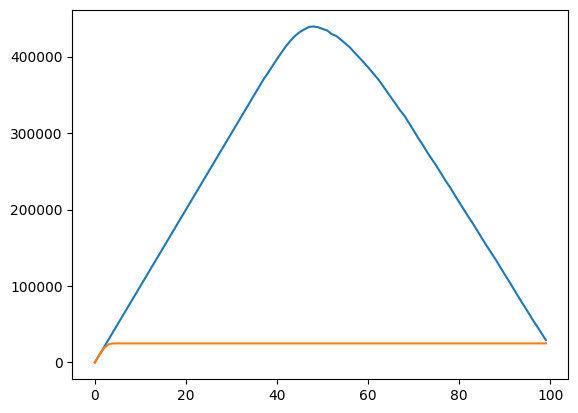

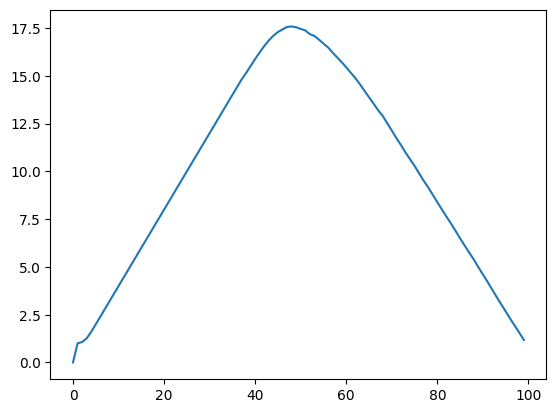

In [188]:
# Plot results along with upper bound from one shot optimization

num_time_steps = 100
max_users = 10000

baseline = simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=num_time_steps, total_capacity=10,
                     max_users=max_users, revenue_factor=100, penalty_factor=0, distribution="uniform",
                     use_stage_1=True, use_stage_2=False, use_stage_3=False)

distribution_matrix = [5.91677119e+0, 5.18575884e+01, 5.97489252e+01, 4.51125420e+01,
                       4.93198736e+0, 5.19111283e+01, 5.37295220e+01, 5.04431644e+01,
                       5.20819455e+0, 5.15175474e+01, 5.76694996e+01, 4.88162521e+01,
                       3.81451039e+0, 5.31676958e+01, 6.20434975e+01, 4.29204584e+01,
                       5.78826942e+0, 5.75335927e+01, 4.55318716e+01, 4.05853810e+01,
                       5.62302492e+0, 5.60793817e+01, 4.47804192e+01, 4.30758507e+01,
                       4.73323684e+01]

result_1 = simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=num_time_steps, total_capacity=10,
                     max_users=max_users, revenue_factor=100, penalty_factor=100, distribution="special",
                     distribution_matrix=distribution_matrix,
                     use_stage_1=True, use_stage_2=True, use_stage_3=True)

result_1_profit = np.array(result_1["revenues"]) - np.array(result_1["penalties"])
baseline_profit = np.array(baseline["revenues"]) - np.array(baseline["penalties"])

plt.plot(result_1_profit, label="normal+sharing+nulling")
plt.plot(baseline_profit, label="baseline")
plt.show()

plt.plot(result_1_profit/(1e-12+baseline_profit))
plt.show()

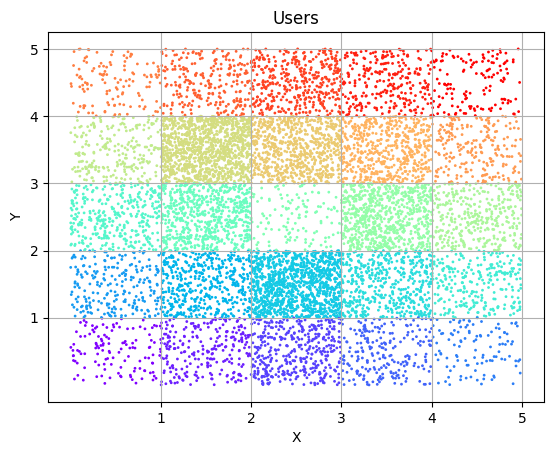

Simulating Time Steps: 100%|██████████| 100/100 [00:00<00:00, 928.22it/s]

Number of users served by nulling: [0, 0, 0, 50, 150, 250, 350, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950, 2045, 2132, 2217, 2292, 2367, 2444, 2516, 2590, 2658, 2742, 2817, 2892, 2957, 3019, 3085, 3148, 3218, 3277, 3333, 3398, 3453, 3511, 3576, 3625, 3675, 3728, 3785, 3823, 3873, 3920, 3973, 4021, 4065, 4107, 4154, 4192, 4231, 4273, 4310, 4353, 4385, 4422, 4450, 4481, 4511, 4550, 4590, 4621, 4661, 4690, 4714, 4737, 4771, 4788, 4813, 4835, 4864, 4890, 4910, 4930, 4957, 4989, 5011, 5045, 5068, 5087, 5110, 5133, 5150, 5172, 5199, 5228, 5260, 5280, 5303, 5321, 5344]
Total number of users: 1000


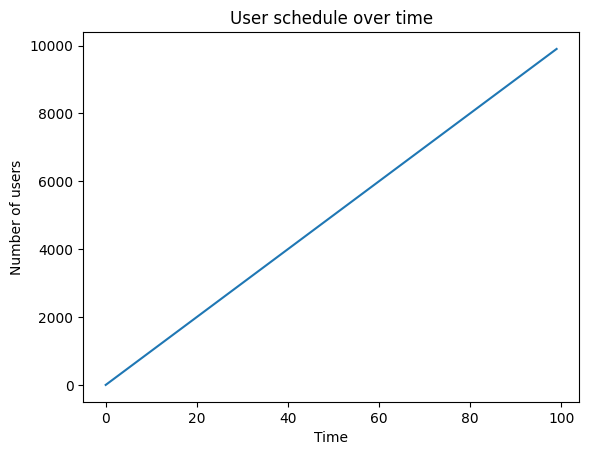

[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 229500, 238200, 246700, 254200, 261700, 269400, 276600, 284000, 290800, 299200, 306700, 314200, 320700, 326900, 333500, 339800, 346800, 352700, 358300, 364800, 370300, 376100, 382600, 387500, 392500, 397800, 403500, 407300, 412300, 417000, 422300, 427100, 431500, 435700, 440400, 444200, 448100, 452300, 456000, 460300, 463500, 467200, 470000, 473100, 476100, 480000, 484000, 487100, 491100, 494000, 496400, 498700, 502100, 503800, 506300, 508500, 511400, 514000, 516000, 518000, 520700, 523900, 526100, 529500, 531800, 533700, 536000, 538300, 540000, 542200, 544900, 547800, 551000, 553000, 555300, 557100, 559400]


In [165]:
num_time_steps = 100
max_users = 10000
result = simulate_leo_mac(num_sats=25, num_cells=25, num_time_steps=num_time_steps, total_capacity=10,
                     max_users=max_users, revenue_factor=100, penalty_factor=100, distribution="random",
                     use_stage_1=True, use_stage_2=True, use_stage_3=True)
user_schedule = generate_user_schedule(num_time_steps, max_users)
plot_user_schedule(user_schedule)



print(result["revenues"])


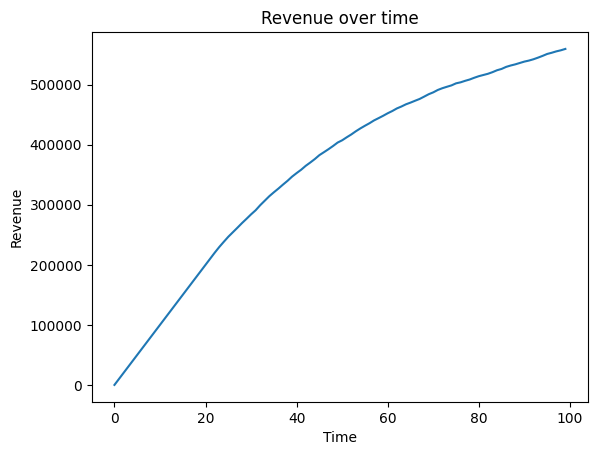

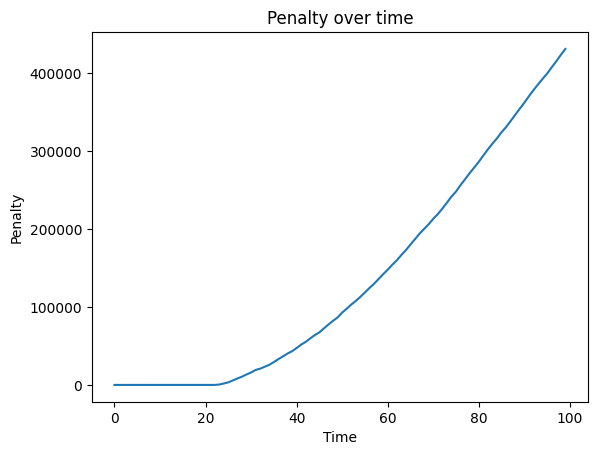

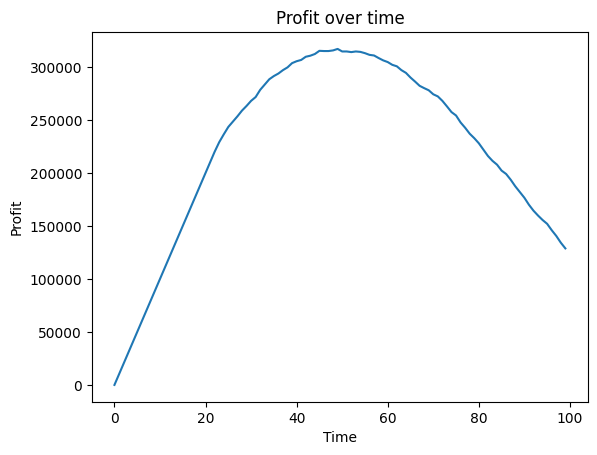

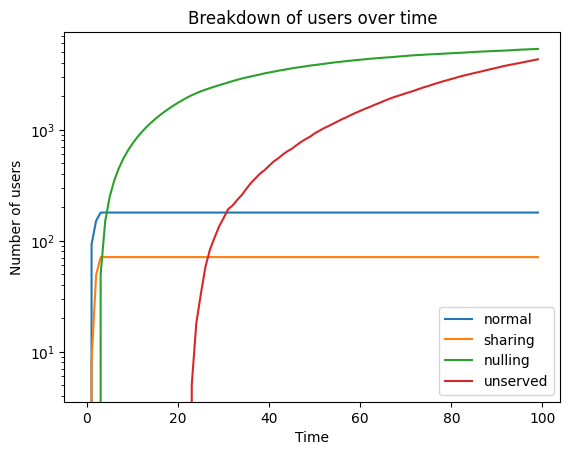

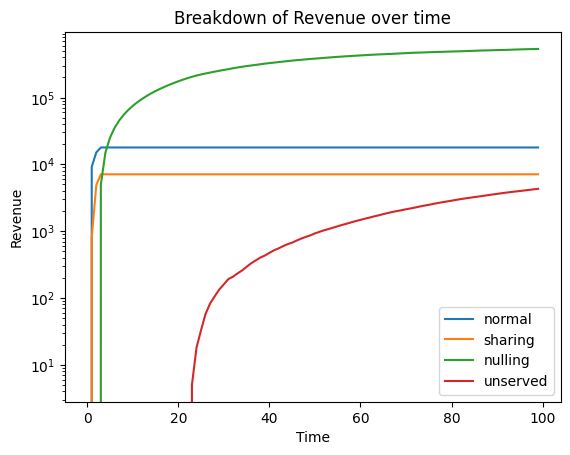

In [166]:
# normal + sharing + nulling
summarize_results(result, num_time_steps, animate=False)

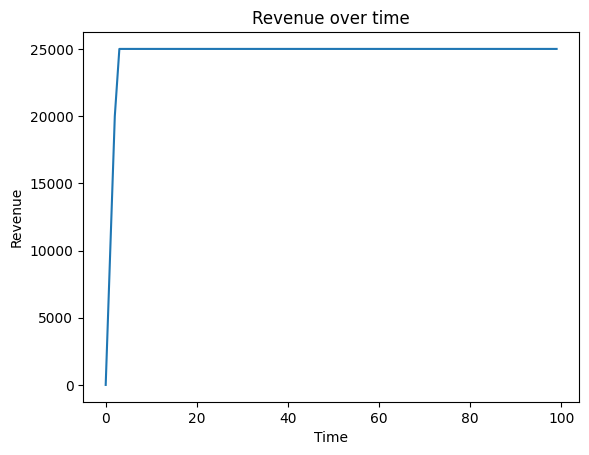

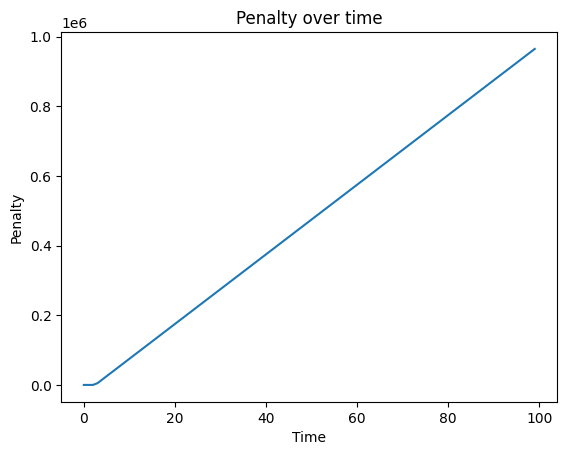

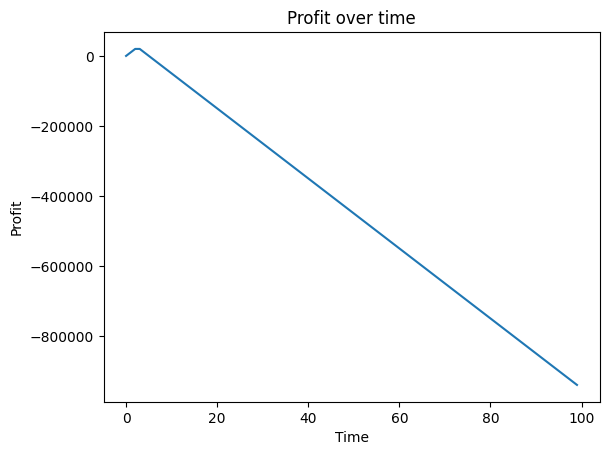

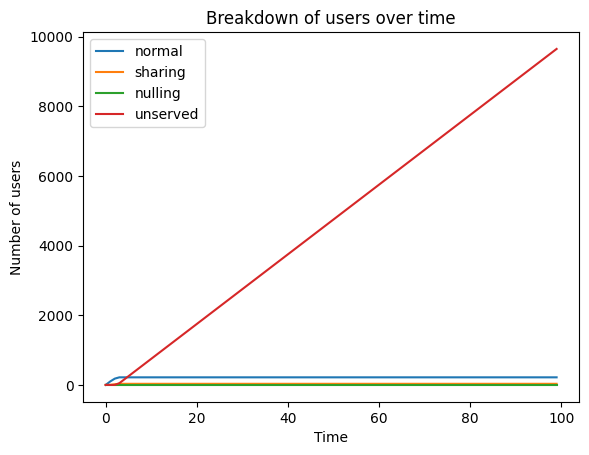

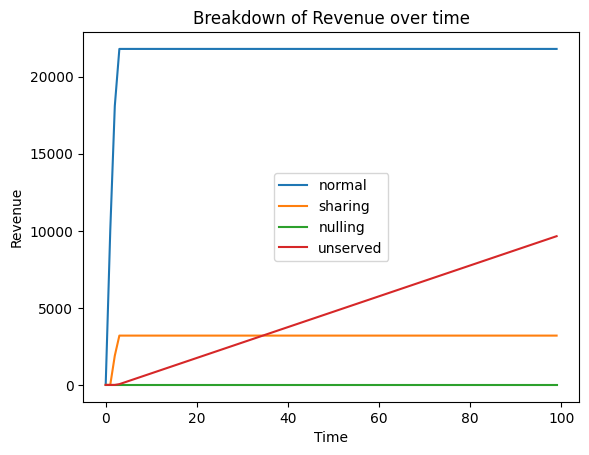

In [136]:
# normal + sharing
summarize_results(result, num_time_steps, animate=False)

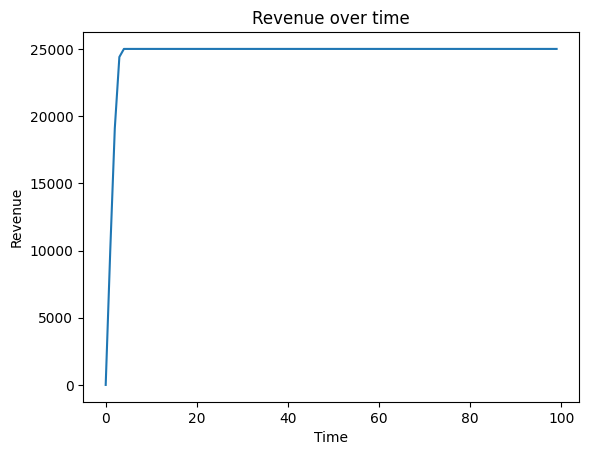

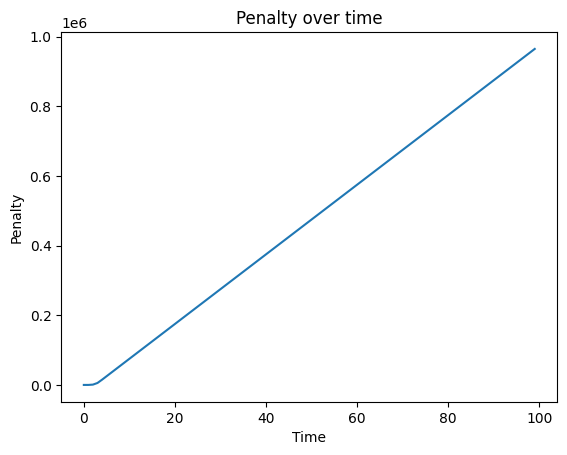

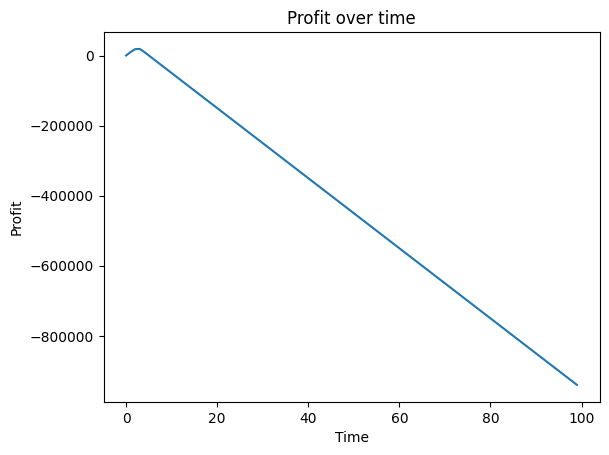

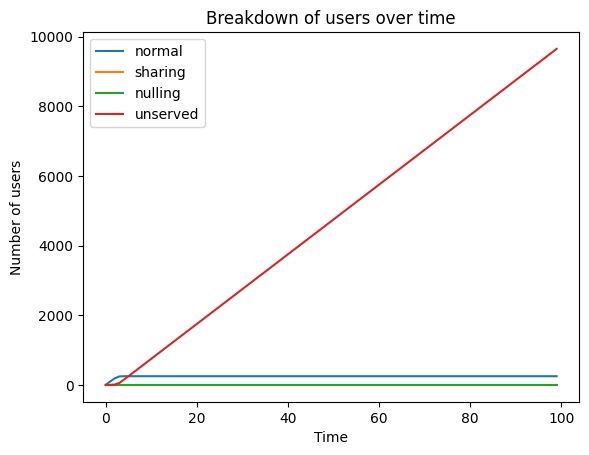

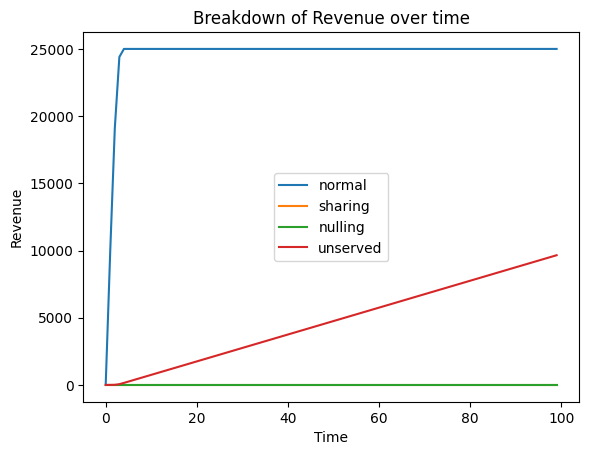

In [133]:
summarize_results(result, num_time_steps, animate=False)